 # Fine-tuning CryptoBERT Model + Hyperparameter Optimisation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import sys

# PATH CONSTANTS
ABSOLUTE_PATH = "/content/drive/My Drive/sentix_nlp"
PREPROCESSED_DATA_DIR = ABSOLUTE_PATH + "/data/preprocessed"
EXPORT_MODEL_DIR = ABSOLUTE_PATH + "/models"

sys.path.insert(0, ABSOLUTE_PATH)

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade transformers optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import optuna
import torch.nn as nn
from torch.utils.data import Dataset
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from transformers import (
  AutoModelForSequenceClassification,
  AutoTokenizer,
  Trainer,
  TrainingArguments,
  EvalPrediction
)

from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
  classification_report,
  confusion_matrix,
  ConfusionMatrixDisplay,
  accuracy_score,
  f1_score
)
from utils import NewsDataset, compute_metrics


# MODEL CONSTANTS
MODEL_NAME="ElKulako/cryptobert"
NUM_LABELS=3
BATCH_SIZE=16
NUM_EPOCHS= 3 #4
LEARNING_RATE= 5e-5 #2e-5
WEIGHT_DECAY=0.01
WARMUP_RATIO=0.1
WARMUP_STEPS=3

 ## Load the model and tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,num_labels=NUM_LABELS
)

 ### Switch to CUDA

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

 ## Load the preprocessed data

In [ ]:
test_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_test.csv")
train_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_train.csv")
val_set_path = os.path.join(PREPROCESSED_DATA_DIR, "coindesk_val.csv")

train_df = pd.read_csv(train_set_path)
val_df = pd.read_csv(val_set_path)
test_df = pd.read_csv(test_set_path)

df = pd.concat([train_df, val_df, test_df], ignore_index=True)
df.head()

,full_text,label
0,singapore exchange to launch bitcoin perpetual...,2
1,market madness continues – learn why hedera hb...,2
2,cardano price forecast can ada rise 5000 a blo...,1
3,when will cardano ada break the 1 barrier . ca...,0
4,bitpanda secures micar license from austria ’ ...,2


In [ ]:
X_train, y_train = train_df['full_text'].values, train_df['label'].values
train_dataset = NewsDataset(X_train, y_train, tokenizer)

X_val, y_val = val_df['full_text'].values, val_df['label'].values
val_dataset = NewsDataset(X_val, y_val, tokenizer)

X_test, y_test = test_df['full_text'].values, test_df['label'].values
test_dataset = NewsDataset(X_test, y_test, tokenizer)

 ## Calculate class weights to handle imbalance

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:
classes = ["Negative", "Neutral", "Positive"]
weights_np = class_weights.cpu().numpy()

df_class_weights = pd.DataFrame({
    "class": classes,
    "weight": weights_np
})

df_class_weights

,class,weight
0,Negative,1.489287
1,Neutral,1.278170
2,Positive,0.646760


 ## Create weighted trainer

 REF: https://discuss.huggingface.co/t/how-can-i-use-class-weights-when-training/1067/7

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def create_optimizer_and_scheduler(self, num_training_steps: int):
        # 1. set up AdamW with decoupled weight decay
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=self.args.learning_rate,
            weight_decay=self.args.weight_decay,
            betas=(0.9, 0.999),
            eps=1e-8
        )

        # 2. linear warmup + decay scheduler
        self.lr_scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.args.warmup_steps,
            num_training_steps=num_training_steps
        )

        return self.optimizer, self.lr_scheduler

    # function necessary to consider the computed weights
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


 ## Hyperparameter Tuning with Optuna

In [ ]:
def compute_objective(metrics):
    # return metrics["accuracy"] * 0.7 + metrics["f1"] * 0.3
    return metrics["eval_accuracy"] * 0.7 + metrics["eval_f1"] * 0.3

def _compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return compute_metrics(preds, labels)

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.001, 0.1, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 24, 32]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.05, 0.2),
        "hidden_dropout_prob": trial.suggest_float("hidden_dropout_prob", 0.1, 0.5),
        "attention_probs_dropout_prob": trial.suggest_float("attention_probs_dropout_prob", 0.1, 0.5),
    }

def model_init(trial):
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        hidden_dropout_prob=trial.params.get("hidden_dropout_prob", 0.3),
        attention_probs_dropout_prob=trial.params.get("attention_probs_dropout_prob", 0.3)
    )


In [ ]:
def run_optuna_optimization():
    base_training_args = TrainingArguments(
        output_dir=os.path.join(EXPORT_MODEL_DIR, "optuna_results"),
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        num_train_epochs=2,  # shorter epochs for tuning
        fp16=torch.cuda.is_available(),
        report_to=["tensorboard"],
        logging_dir=os.path.join(EXPORT_MODEL_DIR, "logs"),
        logging_steps=50,
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        greater_is_better=True,
        remove_unused_columns=True,
    )

    # Using a pruner to terminate unpromising trials early
    pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=0)
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=42),
        pruner=pruner
    )

    def optuna_objective(trial):
        # Update training arguments with current hyperparameters being explored
        hp_params = optuna_hp_space(trial)
        training_args = TrainingArguments(
            output_dir=os.path.join(EXPORT_MODEL_DIR, f"trial_{trial.number}"),
            eval_strategy="epoch",
            save_strategy="epoch",
            save_total_limit=1,
            learning_rate=hp_params["learning_rate"],
            per_device_train_batch_size=hp_params["per_device_train_batch_size"],
            per_device_eval_batch_size=hp_params["per_device_train_batch_size"],
            num_train_epochs=2,  # shorter epochs for tuning
            warmup_ratio=hp_params["warmup_ratio"],
            weight_decay=hp_params["weight_decay"],
            fp16=torch.cuda.is_available(),
            report_to=["tensorboard"],
            logging_dir=os.path.join(EXPORT_MODEL_DIR, "logs"),
            logging_steps=50,
            metric_for_best_model="accuracy",
            load_best_model_at_end=True,
        )

        # Initialise model with current hyperparameters
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=NUM_LABELS,
            hidden_dropout_prob=hp_params["hidden_dropout_prob"],
            attention_probs_dropout_prob=hp_params["attention_probs_dropout_prob"]
        ).to(device)

        trainer = WeightedTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            compute_metrics=_compute_metrics,
            class_weights=class_weights
        )

        trainer.train()
        eval_results = trainer.evaluate()
        objective_value = compute_objective(eval_results)

        # Clean up by removing a saved model to free up space on disk
        if os.path.exists(os.path.join(EXPORT_MODEL_DIR, f"trial_{trial.number}")):
            import shutil
            shutil.rmtree(os.path.join(EXPORT_MODEL_DIR, f"trial_{trial.number}"))

        return objective_value

    print("Starting hyperparameter optimization...")
    study.optimize(optuna_objective, n_trials=15, timeout=None)

    print("Best hyperparameters:", study.best_params)
    print("Best objective value:", study.best_value)

    # Save results
    optuna_results_file = os.path.join(EXPORT_MODEL_DIR, "optuna_study_results.csv")
    study_df = study.trials_dataframe()
    study_df.to_csv(optuna_results_file)

    # Visualize optimisation results
    try:
        from optuna.visualization import plot_optimization_history, plot_param_importances

        # Plot optimisation history
        fig1 = plot_optimization_history(study)
        fig1.write_image(os.path.join(EXPORT_MODEL_DIR, "optuna_history.png"))

        # Plot parameter importances
        fig2 = plot_param_importances(study)
        fig2.write_image(os.path.join(EXPORT_MODEL_DIR, "optuna_param_importances.png"))
    except:
        print("Optuna visualization could not be generated.")

    return study.best_params

In [ ]:
best_params = run_optuna_optimization()

[I 2025-05-06 05:38:12,141] A new study created in memory with name: no-name-c0c5fffa-acec-449d-96a7-6788e552eb7a


Starting hyperparameter optimization...


<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.810200,0.760870,0.732932,0.710095,0.732932,0.711176
2,0.675100,0.825662,0.747657,0.732976,0.747657,0.725103


[I 2025-05-06 05:44:34,237] Trial 0 finished with value: 0.7408910030855345 and parameters: {'learning_rate': 2.368863950364079e-05, 'weight_decay': 0.07969454818643935, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.05871254182522992, 'hidden_dropout_prob': 0.4464704583099741, 'attention_probs_dropout_prob': 0.34044600469728353}. Best is trial 0 with value: 0.7408910030855345.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.572100,0.542833,0.809906,0.806003,0.809906,0.806741
2,0.404600,0.627077,0.825971,0.820624,0.825971,0.821811


[I 2025-05-06 05:50:53,599] Trial 1 finished with value: 0.8247228211476997 and parameters: {'learning_rate': 5.105903209394759e-05, 'weight_decay': 0.0010994335574766201, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07751067647801507, 'hidden_dropout_prob': 0.2216968971838151, 'attention_probs_dropout_prob': 0.3099025726528951}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.764200,0.758598,0.766399,0.750888,0.766399,0.749347
2,0.614300,0.812460,0.789826,0.780904,0.789826,0.779332


[I 2025-05-06 05:57:17,000] Trial 2 finished with value: 0.7866776357418821 and parameters: {'learning_rate': 2.703616066662e-05, 'weight_decay': 0.0038234752246751854, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.1184104976325554, 'hidden_dropout_prob': 0.41407038455720546, 'attention_probs_dropout_prob': 0.1798695128633439}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.111500,1.040091,0.591700,0.543453,0.591700,0.521165
2,0.911500,0.931660,0.566265,0.694223,0.566265,0.578888


[I 2025-05-06 06:01:55,692] Trial 3 finished with value: 0.5705395269860406 and parameters: {'learning_rate': 3.267641765781762e-05, 'weight_decay': 0.015304852121831466, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.192332830588, 'hidden_dropout_prob': 0.4862528132298237, 'attention_probs_dropout_prob': 0.4233589392465845}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.856100,0.743170,0.734940,0.716109,0.734940,0.713032
2,0.750900,0.927028,0.751673,0.738633,0.751673,0.724630


[I 2025-05-06 06:08:13,983] Trial 4 finished with value: 0.7435602024061518 and parameters: {'learning_rate': 2.0165721691808572e-05, 'weight_decay': 0.0015679933916723015, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.05515827816728276, 'hidden_dropout_prob': 0.4637281608315128, 'attention_probs_dropout_prob': 0.20351199264000677}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.126800,1.109339,0.281794,0.515308,0.281794,0.199908
2,1.111300,1.097004,0.433735,0.470374,0.433735,0.386349


[I 2025-05-06 06:12:02,753] Trial 5 finished with value: 0.41951919857777425 and parameters: {'learning_rate': 4.5975057847321686e-05, 'weight_decay': 0.004201672054372531, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.1662699235041672, 'hidden_dropout_prob': 0.4757995766256756, 'attention_probs_dropout_prob': 0.4579309401710595}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.582000,0.534340,0.814592,0.816561,0.814592,0.815302
2,0.469700,0.595608,0.818608,0.812440,0.818608,0.813350


[I 2025-05-06 06:15:54,047] Trial 6 finished with value: 0.8170303417009869 and parameters: {'learning_rate': 3.961867790406586e-05, 'weight_decay': 0.06978281265126034, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.10830159345342232, 'hidden_dropout_prob': 0.20853961270955837, 'attention_probs_dropout_prob': 0.43149500366077176}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.728000,0.705672,0.783133,0.774852,0.783133,0.776560
2,0.654400,0.823970,0.777108,0.768585,0.777108,0.766399


[I 2025-05-06 06:19:59,940] Trial 7 finished with value: 0.7811608633778016 and parameters: {'learning_rate': 2.2738055735631803e-05, 'weight_decay': 0.0036464395589807202, 'per_device_train_batch_size': 24, 'warmup_ratio': 0.19803304049007764, 'hidden_dropout_prob': 0.40889790771866297, 'attention_probs_dropout_prob': 0.17948627261366898}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.576400,0.600181,0.804552,0.799159,0.804552,0.800599
2,0.546900,0.607449,0.805890,0.800000,0.805890,0.801886


[I 2025-05-06 06:24:03,886] Trial 8 finished with value: 0.8046888675103994 and parameters: {'learning_rate': 1.012796325733148e-05, 'weight_decay': 0.04274869455295218, 'per_device_train_batch_size': 24, 'warmup_ratio': 0.1037698592816409, 'hidden_dropout_prob': 0.1463476238100519, 'attention_probs_dropout_prob': 0.4452413703502375}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.115300,1.073684,0.500669,0.582119,0.500669,0.514549
2,0.897400,0.976482,0.340696,0.741023,0.340696,0.267678


[I 2025-05-06 06:27:53,721] Trial 9 finished with value: 0.504833157498126 and parameters: {'learning_rate': 4.2004723167022006e-05, 'weight_decay': 0.004589824181495649, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.14563362070328198, 'hidden_dropout_prob': 0.4548850970305306, 'attention_probs_dropout_prob': 0.28888597006477973}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.720900,0.619934,0.779786,0.782021,0.779786,0.780271
2,0.502600,0.566178,0.803882,0.813175,0.803882,0.806960


[I 2025-05-06 06:32:30,384] Trial 10 finished with value: 0.8048056417138372 and parameters: {'learning_rate': 9.288338406672918e-05, 'weight_decay': 0.0010280029617905613, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.08537422725799389, 'hidden_dropout_prob': 0.2919884385410771, 'attention_probs_dropout_prob': 0.29671335876487964}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.588000,0.505903,0.814592,0.814372,0.814592,0.814460
2,0.427000,0.557593,0.824632,0.821736,0.824632,0.822863


[I 2025-05-06 06:36:21,148] Trial 11 finished with value: 0.8241011303125932 and parameters: {'learning_rate': 7.327169449875371e-05, 'weight_decay': 0.018877457901429077, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.08618438339248478, 'hidden_dropout_prob': 0.2079085005117408, 'attention_probs_dropout_prob': 0.3623646011031012}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.098900,1.078548,0.275770,0.267763,0.275770,0.138810
2,0.727100,0.717680,0.712182,0.720105,0.712182,0.714584


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[I 2025-05-06 06:42:46,892] Trial 12 finished with value: 0.7129027209464767 and parameters: {'learning_rate': 7.62904672613948e-05, 'weight_decay': 0.017029437058373485, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07999096688349955, 'hidden_dropout_prob': 0.24937989204002747, 'attention_probs_dropout_prob': 0.3579072302663711}. Best is trial 1 with value: 0.8247228211476997.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.540300,0.504026,0.807898,0.809912,0.807898,0.808726
2,0.318100,0.532915,0.831995,0.830112,0.831995,0.830924


[I 2025-05-06 06:46:36,867] Trial 13 finished with value: 0.8316735447249012 and parameters: {'learning_rate': 6.229801415331804e-05, 'weight_decay': 0.02665262919639136, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.08269115363959155, 'hidden_dropout_prob': 0.1200830393113325, 'attention_probs_dropout_prob': 0.24727497246201913}. Best is trial 13 with value: 0.8316735447249012.
<ipython-input-26-ca0e3f80ddff>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.531200,0.495364,0.823963,0.823312,0.823963,0.823620
2,0.307500,0.534493,0.831325,0.831275,0.831325,0.831122


[I 2025-05-06 06:50:27,697] Trial 14 finished with value: 0.8312642264936824 and parameters: {'learning_rate': 5.904093948077807e-05, 'weight_decay': 0.03446511659889725, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.1363265218734974, 'hidden_dropout_prob': 0.11940552246951587, 'attention_probs_dropout_prob': 0.10965592371923005}. Best is trial 13 with value: 0.8316735447249012.


Best hyperparameters: {'learning_rate': 6.229801415331804e-05, 'weight_decay': 0.02665262919639136, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.08269115363959155, 'hidden_dropout_prob': 0.1200830393113325, 'attention_probs_dropout_prob': 0.24727497246201913}
Best objective value: 0.8316735447249012
Optuna visualization could not be generated. This usually requires plotly.


 ## Training with the Best Hyperparameters

In [ ]:
def train_with_best_params(best_params):
    # Initialise model with best hyperparameters
    best_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        hidden_dropout_prob=best_params.get("hidden_dropout_prob", 0.3),
        attention_probs_dropout_prob=best_params.get("attention_probs_dropout_prob", 0.3)
    ).to(device)

    best_training_args = TrainingArguments(
        output_dir=os.path.join(EXPORT_MODEL_DIR, "best_model"),
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=2,
        learning_rate=best_params.get("learning_rate", 5e-5),
        per_device_train_batch_size=best_params.get("per_device_train_batch_size", 16),
        per_device_eval_batch_size=best_params.get("per_device_train_batch_size", 16),
        num_train_epochs=NUM_EPOCHS,  # Full training with best params
        warmup_ratio=best_params.get("warmup_ratio", 0.1),
        weight_decay=best_params.get("weight_decay", 0.01),
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        fp16=torch.cuda.is_available(),
        report_to=["tensorboard"],
        logging_dir=os.path.join(EXPORT_MODEL_DIR, "logs"),
        logging_steps=50,
    )

    best_trainer = WeightedTrainer(
        model=best_model,
        args=best_training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=_compute_metrics,
        class_weights=class_weights
    )

    best_trainer.train()

    best_model_path = os.path.join(EXPORT_MODEL_DIR, "best_model_final")
    best_trainer.save_model(best_model_path)
    tokenizer.save_pretrained(best_model_path)

    return best_trainer

In [ ]:
trainer = train_with_best_params(best_params)

Training with best hyperparameters: {'learning_rate': 6.229801415331804e-05, 'weight_decay': 0.02665262919639136, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.08269115363959155, 'hidden_dropout_prob': 0.1200830393113325, 'attention_probs_dropout_prob': 0.24727497246201913}


<ipython-input-26-ca0e3f80ddff>:6: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.551100,0.514004,0.813253,0.809823,0.813253,0.811213
2,0.336200,0.533320,0.829317,0.825244,0.829317,0.826469
3,0.200500,0.640562,0.831995,0.829658,0.831995,0.830634


 ## Evaluate on the test set

In [ ]:
test_results = trainer.evaluate(test_dataset)
test_results

{'eval_loss': 0.6448201537132263,
 'eval_accuracy': 0.8247491638795986,
 'eval_precision': 0.8205826754509884,
 'eval_recall': 0.8247491638795986,
 'eval_f1': 0.8217456269144716,
 'eval_runtime': 5.9268,
 'eval_samples_per_second': 252.242,
 'eval_steps_per_second': 7.93,
 'epoch': 3.0}

In [ ]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       335
           1       0.72      0.64      0.67       390
           2       0.87      0.91      0.89       770

    accuracy                           0.82      1495
   macro avg       0.80      0.80      0.80      1495
weighted avg       0.82      0.82      0.82      1495



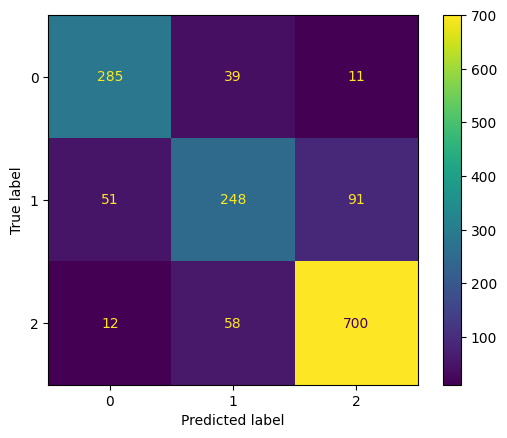

In [ ]:
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

 ## Compare with different hyperparameter sets

In [ ]:
def compare_hyperparameter_sets():
    # The hyperparameter sets to compare
    hp_sets = [
        {"name": "Default", "lr": 5e-5, "wd": 0.01, "bs": 16, "dropout": 0.3},
        {"name": "Higher LR", "lr": 1e-4, "wd": 0.01, "bs": 16, "dropout": 0.3},
        {"name": "Higher Dropout", "lr": 5e-5, "wd": 0.01, "bs": 16, "dropout": 0.5},
        {"name": "Larger Batch", "lr": 5e-5, "wd": 0.01, "bs": 32, "dropout": 0.3},
    ]

    results = []
    for hp_set in hp_sets:
        print(f"\nTraining with {hp_set['name']} configuration...")

        hp_model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=NUM_LABELS,
            hidden_dropout_prob=hp_set["dropout"],
            attention_probs_dropout_prob=hp_set["dropout"]
        ).to(device)

        hp_training_args = TrainingArguments(
            output_dir=os.path.join(EXPORT_MODEL_DIR, f"compare_{hp_set['name']}"),
            eval_strategy="epoch",
            save_strategy="epoch",
            save_total_limit=1,
            learning_rate=hp_set["lr"],
            per_device_train_batch_size=hp_set["bs"],
            per_device_eval_batch_size=hp_set["bs"],
            num_train_epochs=2,  # shorter for comparison
            warmup_ratio=0.1,
            weight_decay=hp_set["wd"],
            metric_for_best_model="accuracy",
            load_best_model_at_end=True,
            fp16=torch.cuda.is_available(),
            report_to=["tensorboard"],
            logging_dir=os.path.join(EXPORT_MODEL_DIR, "logs"),
            logging_steps=50,
        )

        hp_trainer = WeightedTrainer(
            model=hp_model,
            args=hp_training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=tokenizer,
            compute_metrics=_compute_metrics,
            class_weights=class_weights
        )

        hp_trainer.train()
        eval_results = hp_trainer.evaluate()

        # Save results
        results.append({
            "config": hp_set["name"],
            "accuracy": eval_results["eval_accuracy"],
            "f1": eval_results["eval_f1"],
            "loss": eval_results["eval_loss"]
        })

        # Clean up
        import shutil
        if os.path.exists(os.path.join(EXPORT_MODEL_DIR, f"compare_{hp_set['name']}")):
            shutil.rmtree(os.path.join(EXPORT_MODEL_DIR, f"compare_{hp_set['name']}"))

    results_df = pd.DataFrame(results)
    print("\nHyperparameter Comparison Results:")
    print(results_df)

    # Plot results (accuracy, F1 score, loss...)
    plt.figure(figsize=(12, 6))

    ax1 = plt.subplot(1, 2, 1)
    results_df.plot(x="config", y=["accuracy", "f1"], kind="bar", ax=ax1)
    ax1.set_title("Accuracy and F1 Score")
    ax1.set_ylabel("Score")
    ax1.set_ylim(0, 1)

    ax2 = plt.subplot(1, 2, 2)
    results_df.plot(x="config", y=["loss"], kind="bar", ax=ax2, color="red")
    ax2.set_title("Validation Loss")
    ax2.set_ylabel("Loss")

    plt.tight_layout()
    plt.savefig(os.path.join(EXPORT_MODEL_DIR, "hyperparameter_comparison.png"))
    plt.show()

    return results_df

# compare_results = compare_hyperparameter_sets()